In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats.api as sms
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot

C:\Users\Public\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv(r'C:\Users\Adam Parente\Documents\Python Projects\mortgage\hmda_lar\hmda_lar.csv')

MemoryError: Unable to allocate 128. KiB for an array with shape (16384,) and data type float64

Initial Data Cleaning:

In [ ]:
data.info()

In [ ]:
data.isna().mean()

Handle Null Values:

In [ ]:


data['applicant_income']=data['applicant_income_000s']*1000
data['loan_amount']=data['loan_amount_000s']*1000


data['app_income-median_income'] = data['applicant_income']-data['hud_median_family_income']
data['app-median_%diff'] = data['app_income-median_income']/data['hud_median_family_income']

data['applicant_income']= data['applicant_income'].fillna(
    value=((data['app-median_%diff'].median()*data['hud_median_family_income'])+
 (data['hud_median_family_income']+data['app_income-median_income'].median()))/2)

Remove extra variables:

In [ ]:

drop_columns = ['rate_spread','co_applicant_race_name_5','co_applicant_race_name_4','co_applicant_race_name_3','co_applicant_race_name_2','applicant_race_name_5',
               'applicant_race_name_4','applicant_race_name_3','applicant_race_name_2','application_date_indicator','denial_reason_name_3','denial_reason_name_2',
               'denial_reason_name_2','edit_status_name','sequence_number','denial_reason_name_1','loan_amount_000s','applicant_income_000s','msamd_name',
                'app_income-median_income','app-median_%diff','hoepa_status_name','respondent_id']
data = data.drop(columns=drop_columns,errors='ignore')

Remove last null values:

In [ ]:

data = data.dropna(axis=0,subset=['hud_median_family_income','minority_population','number_of_owner_occupied_units','number_of_1_to_4_family_units','county_name','loan_amount'])

Redefine features and make mortgage approval (action_taken_name) binary

In [ ]:

data['action_taken_binary']=np.where(data['action_taken_name'].isin(['Loan originated','Loan purchased by the institution']),1,0)


action_dic = {'Application denied by financial institution':'denied_not_accepted',
              'Application approved but not accepted':'denied_not_accepted',
              'Preapproval request denied by financial institution':'denied_not_accepted',
              'Preapproval request approved but not accepted':'denied_not_accepted'
             }


data['action_taken_name']=data['action_taken_name'].replace(action_dic)

temp_dict = {'One-to-four family dwelling (other than manufactured housing)':'One-to-four family dwelling'}
data['property_type_name']=data['property_type_name'].replace(temp_dict)

temp_dict = {'Not applicable':'Unknown','Information not provided by applicant in mail, Internet, or telephone application':'Unknown'}
data['applicant_sex_name']=data['applicant_sex_name'].replace(temp_dict)

temp_dict = {'Information not provided by applicant in mail, Internet, or telephone application':'Unknown',
              'Not applicable':'Unknown'}
data['applicant_race_name_1']=data['applicant_race_name_1'].replace(temp_dict)

data['applicant_race_name_1']=np.where(data['applicant_ethnicity_name']=='Hispanic or Latino','Hispanic',data['applicant_race_name_1'])

Continue to narrow down what features to use in modeling:

In [ ]:
#columns to keep, reduce feature count
important_col = ['population','state_abbr','census_tract_number','county_name','minority_population',
       'property_type_name', 'preapproval_name',
       'owner_occupancy_name', 'loan_type_name', 'loan_purpose_name',
       'lien_status_name',
       'applicant_sex_name',
       'applicant_race_name_1', 'agency_name',
       'applicant_income',
       'loan_amount',
       'hud_median_family_income',
       'number_of_owner_occupied_units',
       'number_of_1_to_4_family_units',
       'tract_to_msamd_income',
       'action_taken_binary'
        ]

Generate Dummy Variables:

In [ ]:
cat_col = []
num_col = []
for col in important_col:
    if data[col].dtype==object:
        cat_col.append(col)
    else:
        num_col.append(col)
cat_col.remove('state_abbr')
cat_col.remove('county_name')

In [ ]:
data_dummies = pd.get_dummies(data[important_col],columns=cat_col,drop_first=True)

Aggregate Data at the census tract level (sub county):
This was done for performance issues as much as to normalize the outcome.
Previous attempts at classification on approval were lackluster and slow.
There are about 14 million cases in the orignal dataset.
The focus on neighborhood characteristics makes this a useful aggregation.

In [ ]:
group_dic ={}
for col in data_dummies.columns:
    if data_dummies[col].dtype=='uint8':
        group_dic[col]=['sum','mean']
    elif data_dummies[col].dtype in (['float64','int32']):
        group_dic[col]='mean'
    else:
        pass
group_dic['census_tract_number']='count'

In [ ]:
#generate tract aggregates
#tracts are only unique within their county
data_group = data_dummies.groupby([data_dummies.state_abbr,data_dummies.county_name,data_dummies.census_tract_number]).agg(group_dic)

Generate new features from aggregation and redefine some variables:

In [ ]:
column_rename = {'census_tract_number':'count'}

data_group=data_group.rename(columns=column_rename)


data_group=data_group[data_group[('count','count')]>10]

data_group['male_female_ratio'] = data_group[('applicant_sex_name_Male', 'sum')]/data_group[('applicant_sex_name_Female', 'sum')]

data_group['male_female_ratio']=data_group['male_female_ratio'].replace(np.inf,54)

data_group['number_of_owner_occupied_units_per_cap']=data_group[('number_of_owner_occupied_units','mean')]/data_group[('population','mean')]
data_group['number_of_1_to_4_family_units_per_cap']=data_group[('number_of_1_to_4_family_units','mean')]/data_group[('population','mean')]

data_group=data_group.drop(columns=[('number_of_owner_occupied_units','mean'),('number_of_1_to_4_family_units','mean')])

data_group=data_group.dropna()

Reorganize data to drop sums and counts to remove extra tier for dataset

In [ ]:
drop_col = []
keep_col =[]
for col in data_group.columns:
    if 'count' in col:
        drop_col.append(col)
    elif 'sum' in col:
        drop_col.append(col)
    else:
        keep_col.append(col)

data_group = data_group.drop(columns=drop_col)
data_group.columns=data_group.columns.droplevel(1)

Get the log of income and loan amount:
Other variables were originally tested as their distributions are similarly skewed, but the distribution of the log was not much of an improvement to justify the loss in coherence for most variables.

In [ ]:
def make_log(df,col):
    df[col+'_log']=np.log(df[col].replace(0,.0001))
    plt.figure(figsize=(15,10))
    plt.subplot(4,3,1)
    sns.distplot(df[col])
    plt.title(col)
    plt.subplot(4,3,2)
    sns.distplot(df[col+'_log'])
    plt.title(col+'_log')
    plt.show()

In [ ]:
for col in ['applicant_income', 'loan_amount']:
    make_log(data_group,col)
data_group=data_group.drop(columns=['applicant_income', 'loan_amount'])

Resolve correlation issues:

In [ ]:
corr_pd = pd.DataFrame(columns=['var1','var2','corr'])
var1 =[]
var2 =[]
corr =[]
for i in range(len(data_group.columns)):
    for l in range(i+1,len(data_group.columns)):
        corr_score = data_group[data_group.columns[i]].corr(data_group[data_group.columns[l]])
        var1.append(data_group.columns[i])
        var2.append(data_group.columns[l])
        corr.append(corr_score)

corr_pd=pd.DataFrame({'var1':var1,'var2':var2,'corr':corr})
corr_pd[np.abs(corr_pd['corr'])>.50]

Lists of the most highly correlated variables:
Not all highly correlated variables are removed because they are important to the analysis such as minority population and house ownership

In [ ]:
high_corr_cols =['applicant_race_name_1_White','property_type_name_Manufactured housing','owner_occupancy_name_Not applicable','preapproval_name_Not applicable',
'owner_occupancy_name_Not owner-occupied as a principal dwelling','loan_type_name_FHA-insured','lien_status_name_Not secured by a lien',
'loan_purpose_name_Refinancing','applicant_sex_name_Female','applicant_sex_name_Unknown','loan_amount_log']
medium_corr_cols=['applicant_race_name_1_Black or African American','applicant_race_name_1_Hispanic','applicant_race_name_1_Unknown',]

data_group=data_group.drop(columns=high_corr_cols,errors='ignore')
data_group=data_group.drop(columns=medium_corr_cols,errors='ignore')

In [ ]:
plt.figure(figsize=(30,25))
sns.heatmap(data_group.corr(),vmin=-1,vmax=1,annot=True)
plt.show()

Model Generation:

In [ ]:
#minimum variable removal for all models
X_remove_col_master_list = ['action_taken_binary','population']

Select K Best Model to remove unimportant variables:

In [ ]:
X= data_group.drop(columns=X_remove_col_master_list)
y= data_group['action_taken_binary']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=32)



preprocessing = ColumnTransformer(
    [
        ('scaler', StandardScaler(), X.columns)
    ],
    remainder="passthrough",
)

pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ('select_best', SelectKBest(f_regression,k=20))
    ], verbose=True
)


best_50 = pipeline.fit(X_train,y_train)

In [ ]:
feature_scores = pd.DataFrame({'var':X.columns,'importance':best_50.named_steps["select_best"].scores_})
feature_scores =feature_scores.sort_values(axis=0,by='importance',ascending=False)

Feature importance ranking:

In [ ]:
feature_scores.head(50)

Off of select K best, drop the lowest ones, but also lien_status_name_Not applicable
Unknown or not applicable variables are difficult to explain.  Alternative from that original categorical variable are preferable

In [ ]:
weak_features=feature_scores['var'][feature_scores['importance']<300].values.tolist()
bad_features = ['lien_status_name_Not applicable']
kbest_drop = weak_features + bad_features

Functions for the vif test and general model performance metrics:

In [ ]:
def vif_test(X_train):
    vifs = []
    for i in range(X_train.shape[1]):
        vif = variance_inflation_factor(X_train.values, i)
        vifs.append(vif)
    display(pd.Series(vifs, index=X_train.columns, name='vif table'))

In [ ]:
#scores of model strength and metrics for linear regression
#none of the models pass the linear regression tests
def model_metrics(model):
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    evaluators = ['r^2_train','r^2_test','mae','mse','rmse']
    evaluations = [model.score(X_train,y_train),
                  model.score(X_test,y_test),
                  mean_absolute_error(y_test, y_pred_test),
                  mse(y_test, y_pred_test),
                  rmse(y_test, y_pred_test)]

    evaluation_df = pd.DataFrame({'evaluators': evaluators,'values':evaluations})

    plt.scatter(y_test, y_pred_test)
    plt.plot(y_test, y_test, color="red")
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.title("Charges: true and predicted values")
    plt.show()

    display(evaluation_df)
    
    train_resid = y_train - y_pred_train
    test_resid = y_test - y_pred_test
    _, _, _, p = sms.het_breuschpagan(train_resid, X_train)
    jb_stats = jarque_bera(train_resid)
    norm_stats = normaltest(train_resid)
    qqplot(train_resid, line="s")
    print('breuschpagan:', p)
    print('jarque_bera:', jb_stats)
    print('normaltest:', norm_stats)
    plt.show()

While removing the variables with high vif scores addresses multicolinearity, previous models saw a general drop of at least .1 for r^2.  I decided to keep these variables in to improve the predictive power of the models.  Some variables were too important to remove.

In [ ]:
remove_cols = X_remove_col_master_list+kbest_drop
X= data_group.drop(columns=remove_cols)
y= data_group['action_taken_binary']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=32)

In [ ]:
vif_drop =['applicant_income_log','property_type_name_One-to-four family dwelling','owner_occupancy_name_Owner-occupied as a principal dwelling',
           'applicant_race_name_1_American Indian or Alaska Native']

vif_test(X_train.drop(columns=vif_drop))

Elastic Net Model with Standardization:

In [ ]:
remove_cols = X_remove_col_master_list+kbest_drop
X= data_group.drop(columns=remove_cols)
y= data_group['action_taken_binary']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=32)


preprocessing = ColumnTransformer(
    [
        ('scaler', StandardScaler(), X_train.columns)
    ],
    remainder="passthrough",
)

pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ('elastic', ElasticNet())
    ], verbose=True
)


grid = {
    "elastic__alpha": [.05,.1,.15,.2,.25],
    "elastic__l1_ratio": [.05,.1,.15,.2,.25],
    'elastic__normalize': [True,False],
    "elastic__max_iter": [1000],
}

pipeline_cv1 = GridSearchCV(pipeline, grid, verbose=1,cv=5,n_jobs=3)
pipeline_cv1.fit(X_train, y_train)
#try in reverse

In [ ]:
model_metrics(pipeline_cv1)
print(pipeline_cv1.best_params_)

The model performed somewhat well, explaining about 50% of the variance.  Overfitting is not an issue.  The transition from over to under predicting as y values increase is somewhat problematic.
It is notable that the alpha and l1 ratio perform better closer to 0.  I follow this up with a regular linear regression based on those values.

In [ ]:
coef = pipeline_cv1.best_estimator_.named_steps["elastic"].coef_
coef_pd = pd.DataFrame({'var':X_train.columns,'coef':coef})
coef_pd =coef_pd.sort_values(axis=0,by='coef',ascending=False)
coef_pd

These coefficients are standardized.  The important aspect is that a change of 1 standard deviation has the most impact for minority population, home improvement and 1-4 family dwelling.  Even without p values, these variables were ranked highly by select k best.

Linear Regression with Standaridization:

In [ ]:
remove_cols = X_remove_col_master_list+kbest_drop
X= data_group.drop(columns=remove_cols)
y= data_group['action_taken_binary']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=32)


preprocessing = ColumnTransformer(
    [
        ('scaler', StandardScaler(), X_train.columns)
    ],
    remainder="passthrough",
)

pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ('lin_reg', LinearRegression())
    ], verbose=True
)


grid = {
    'lin_reg__normalize': [True,False]
}

pipeline_cv2 = GridSearchCV(pipeline, grid, verbose=1,cv=5,n_jobs=3)
pipeline_cv2.fit(X_train, y_train)

In [ ]:
model_metrics(pipeline_cv2)
print(pipeline_cv2.best_params_)

This is a slightly improvement over the Elastic Net model.  The issue with going from over to under predicting remains

In [ ]:
coef = pipeline_cv2.best_estimator_.named_steps["lin_reg"].coef_
coef_pd = pd.DataFrame({'var':X_train.columns,'coef':coef})
coef_pd =coef_pd.sort_values(axis=0,by='coef',ascending=False)
coef_pd

Not much different from the Elastic Net model.  Minority Population, home improvement and one to four family dwelling remain the most prominent variables.  The slight improvement in r^2 is likely due to the weaker variables having a greater input in this model (fewer 0 coefficients).

In [ ]:
Random Forest:

In [ ]:
remove_cols = X_remove_col_master_list+kbest_drop
X= data_group.drop(columns=remove_cols)
y= data_group['action_taken_binary']


X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=32)


preprocessing = ColumnTransformer(
    [
        ('scaler', StandardScaler(), X_train.columns)
    ],
    remainder="passthrough",
)

pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ('forest', RandomForestRegressor())
    ], verbose=True
)


grid = {
    "forest__n_estimators": [100],
    'forest__min_samples_split': [25],
    "forest__max_depth": [10],
    "forest__max_features": [10,15],
    "forest__min_samples_leaf": [10]
}

pipeline_cv3 = GridSearchCV(pipeline, grid, verbose=1,cv=3,n_jobs=3)
pipeline_cv3.fit(X_train, y_train)

In [ ]:
model_metrics(pipeline_cv3)
print(pipeline_cv3.best_params_)

This model performs better, but with a little overfit.  The parameters were set to reduce overfit, but maintain an improvement in the r^2 value.  The continued under and over predicting suggests that it is not a quirk of the linear model.  Again, previous efforts at winsorizing and removing variable with high vif scores had a strong negative impact on r^2 values across models. 

In [ ]:
feature_import = pipeline_cv3.best_estimator_.named_steps["forest"].feature_importances_
feature_import_pd = pd.DataFrame({'var':X_train.columns,'importance':feature_import})
feature_import_pd =feature_import_pd.sort_values(axis=0,by='importance',ascending=False)
feature_import_pd

While there aren't coefficients, the model does continue to emphasize the same variables as previous models.  Minority Population and 1-4 Family dwelling are noticeably stronger than the remaining variables and do the heavy lifting in the model.

Elastic (no standardization):
To better reflect on coefficients, I ran both the elastic net and linear regression models to get more easily interpretable coefficients.

In [ ]:
#Elastic, non standardized

remove_cols = X_remove_col_master_list+kbest_drop
X= data_group.drop(columns=remove_cols)
y= data_group['action_taken_binary']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=32)



pipeline = Pipeline(
    [
        ('elastic', ElasticNet())
    ], verbose=True
)


grid = {
    "elastic__alpha": [.05,.1,.15,.2,.25],
    "elastic__l1_ratio": [.05,.1,.15,.2,.25],
    'elastic__normalize': [True,False],
    "elastic__max_iter": [1000],
}

pipeline_cv4 = GridSearchCV(pipeline, grid, verbose=1,cv=5,n_jobs=3)
pipeline_cv4.fit(X_train, y_train)

In [ ]:
model_metrics(pipeline_cv4)
print(pipeline_cv4.best_params_)

This model is abysmal with a large drop in the r^2 value.  Predictions are terrible.

In [ ]:
coef = pipeline_cv4.best_estimator_.named_steps["elastic"].coef_
coef_pd = pd.DataFrame({'var':X_train.columns,'coef':coef})
coef_pd =coef_pd.sort_values(axis=0,by='coef',ascending=False)
coef_pd

In [ ]:
Linear Regression (nonstandardized):

In [ ]:
remove_cols = X_remove_col_master_list+kbest_drop
X= data_group.drop(columns=remove_cols)
y= data_group['action_taken_binary']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=32)

pipeline = Pipeline(
    [
        ('lin_reg', LinearRegression())
    ], verbose=True
)


grid = {
    'lin_reg__normalize': [True,False]
}

pipeline_cv5 = GridSearchCV(pipeline, grid, verbose=1,cv=5,n_jobs=3)
pipeline_cv5.fit(X_train, y_train)

In [ ]:
model_metrics(pipeline_cv5)
print(pipeline_cv5.best_params_)

This model performs similarly to the standardized linear regression.  I use it for coefficient comparison

In [ ]:
coef = pipeline_cv5.best_estimator_.named_steps["lin_reg"].coef_
coef_pd = pd.DataFrame({'var':X_train.columns,'coef':coef})
coef_pd =coef_pd.sort_values(axis=0,by='coef',ascending=False)
coef_pd

The key values have very similar impacts.  For example an increase in the minority population % by 30 points (the standard deviation) is ~-3.6%, identical to the -3.6% predicted by the standardized linear regression

While charts would usually be up front, I wanted to focus on specific relationships rather than a long series of charts for variables ultimately drop/ignored:

In [123]:
#setup for chart generation
remove_cols = X_remove_col_master_list+kbest_drop
remove_cols.remove('action_taken_binary')
X= data_group.drop(columns=remove_cols)
folder=r'C:\Users\Adam Parente\Documents\Python Projects\mortgage\\'
sns.set_style("whitegrid")

In [124]:
#generate temporary binary variables for chart comparisons
X['rich']= X['hud_median_family_income']>X['hud_median_family_income'].mean()
X['above_avg_acceptance']= X['action_taken_binary']>X['action_taken_binary'].mean()
X['above_avg_home_ownership']= X['number_of_owner_occupied_units_per_cap']>X['number_of_owner_occupied_units_per_cap'].mean()

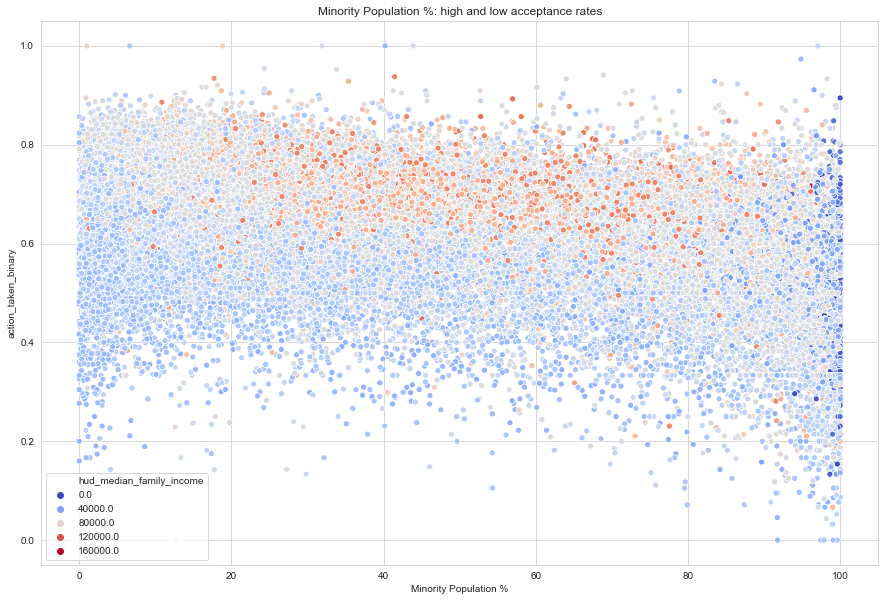

In [125]:
#not the best graph
plt.figure(figsize=(15,10))
sns.scatterplot(x='minority_population',y='action_taken_binary',data=X,hue='hud_median_family_income',palette='coolwarm')
plt.title('Minority Population %: high and low acceptance rates')
plt.xlabel('Minority Population %')
plt.legend()
plt.show()

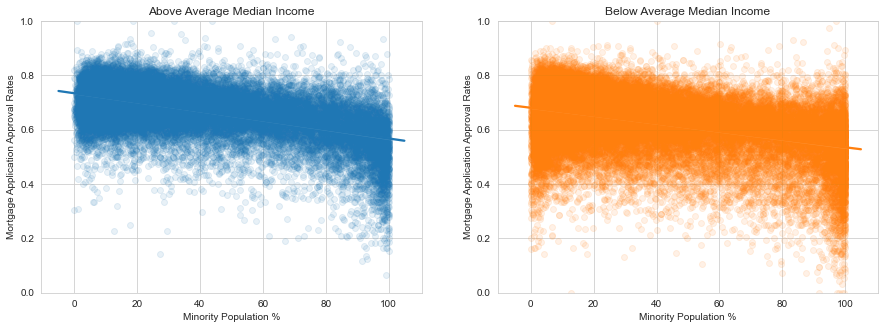

In [126]:
#separated because the overlap was messy like above
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)

sns.regplot(x='minority_population',y='action_taken_binary',data=X[X['rich']==True],scatter_kws={'alpha':0.1},label='Above Average Median Income',ax=ax1)
sns.regplot(x='minority_population',y='action_taken_binary',data=X[X['rich']==False],scatter_kws={'alpha':0.1}, label='Below Average Median Income',ax=ax2)
ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax1.set_xlabel('Minority Population %')
ax2.set_xlabel('Minority Population %')
ax1.set_ylabel('Mortgage Application Approval Rates')
ax2.set_ylabel('Mortgage Application Approval Rates')
ax1.set_title('Above Average Median Income')
ax2.set_title('Below Average Median Income')
plt.savefig(fname=folder+'minority&acceptance&income')
plt.show()

Slight shift in the line of best fit, about .05 difference

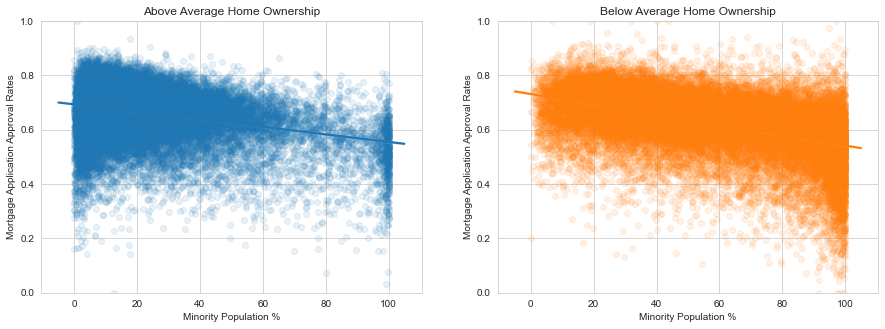

In [127]:
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)

sns.regplot(x='minority_population',y='action_taken_binary',data=X[X['above_avg_home_ownership']==True],scatter_kws={'alpha':0.1},label='Above Average Median Income',ax=ax1)
sns.regplot(x='minority_population',y='action_taken_binary',data=X[X['above_avg_home_ownership']==False],scatter_kws={'alpha':0.1}, label='Below Average Median Income',ax=ax2)
ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax1.set_xlabel('Minority Population %')
ax2.set_xlabel('Minority Population %')
ax1.set_ylabel('Mortgage Application Approval Rates')
ax2.set_ylabel('Mortgage Application Approval Rates')
ax1.set_title('Above Average Home Ownership')
ax2.set_title('Below Average Home Ownership')
plt.savefig(fname=folder+'minority&acceptance&ownership')
plt.show()

similar story with a slight shift in the line.

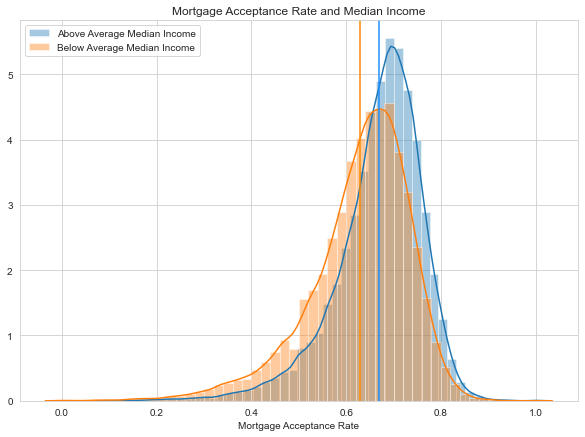

In [128]:
plt.figure(figsize=(10,7))
sns.distplot(X['action_taken_binary'][X['rich']==True],label='Above Average Median Income')
sns.distplot(X['action_taken_binary'][X['rich']==False],label='Below Average Median Income')
plt.title('Mortgage Acceptance Rate and Median Income')
plt.xlabel('Mortgage Acceptance Rate')
plt.axvline(x=X['action_taken_binary'][X['rich']==True].mean(),color='dodgerblue')
plt.axvline(x=X['action_taken_binary'][X['rich']==False].mean(),color='darkorange')
plt.legend()
plt.savefig(fname=folder+'median_income&acceptance')
plt.show()

I decided to use distribution plots for most graphs in my presentation as the key takeaway is clearer, such as the difference between high and low median income

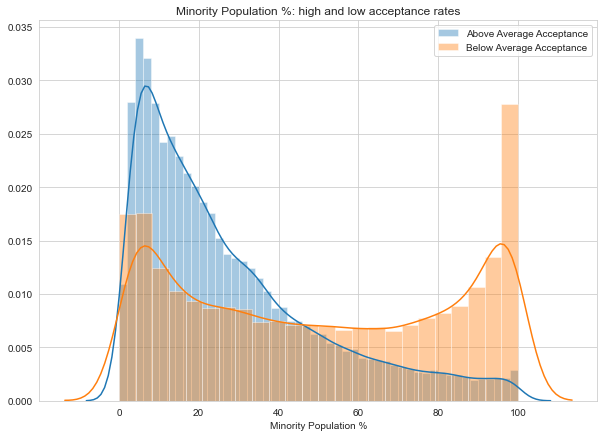

In [129]:
plt.figure(figsize=(10,7))
sns.distplot(X['minority_population'][X['above_avg_acceptance']==True],label='Above Average Acceptance')
sns.distplot(X['minority_population'][X['above_avg_acceptance']==False], label='Below Average Acceptance')
plt.title('Minority Population %: high and low acceptance rates')
plt.xlabel('Minority Population %')
plt.legend()
plt.savefig(fname=folder+'minority&acceptance')
plt.show()

The above graph is a key part of the story with visibly different approval rates for high minority communities.

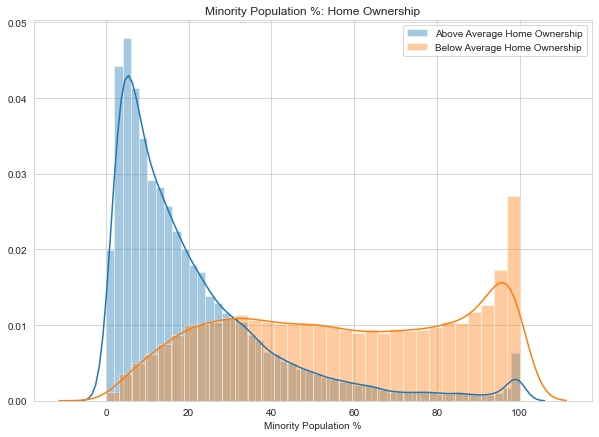

In [130]:
plt.figure(figsize=(10,7))
sns.distplot(X['minority_population'][X['above_avg_home_ownership']==True],label='Above Average Home Ownership')
sns.distplot(X['minority_population'][X['above_avg_home_ownership']==False], label='Below Average Home Ownership')
plt.title('Minority Population %: Home Ownership')
plt.xlabel('Minority Population %')
plt.legend()
plt.savefig(fname=folder+'minority&homeownership')
plt.show()

While there is a difference between minority and nonminority communities, other aspects have visible differences too such as home ownership which follows a similar trend.

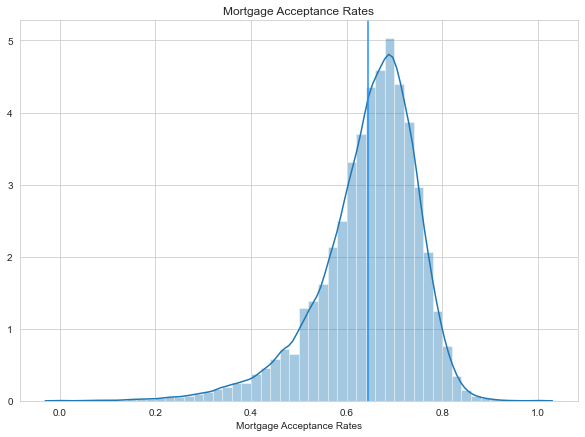

In [131]:
plt.figure(figsize=(10,7))
sns.distplot(X['action_taken_binary'])
plt.title('Mortgage Acceptance Rates')
plt.xlabel('Mortgage Acceptance Rates')
plt.axvline(x=X['action_taken_binary'].mean(),color='dodgerblue')
plt.savefig(fname=folder+'acceptancerates')
plt.show()

The above graph shows the distribution of mortgage acceptance rates with an average of about .65.  There is enough variance to justify this project.

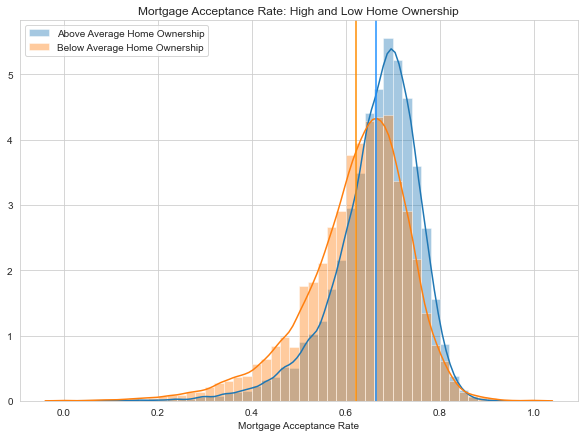

In [132]:
plt.figure(figsize=(10,7))
sns.distplot(X['action_taken_binary'][X['above_avg_home_ownership']==True],label='Above Average Home Ownership')
sns.distplot(X['action_taken_binary'][X['above_avg_home_ownership']==False],label='Below Average Home Ownership')
plt.title('Mortgage Acceptance Rate: High and Low Home Ownership')
plt.xlabel('Mortgage Acceptance Rate')
plt.legend()
plt.axvline(x=X['action_taken_binary'][X['above_avg_home_ownership']==True].mean(),color='dodgerblue')
plt.axvline(x=X['action_taken_binary'][X['above_avg_home_ownership']==False].mean(),color='darkorange')
plt.savefig(fname=folder+'houseownership&acceptance')
plt.show()

The last graph here shows the acceptance rate difference between high and low home ownership.  Similar to the earlier scatterplots, the difference is about .05.

I was curious if the model would diverge when applied to a subset of the data, in this case median income.  Two linear regressions:  one for 'poor' and one for 'rich'.  These are standardized

In [133]:
poor = data_group[data_group['hud_median_family_income']<(data_group['hud_median_family_income'].mean()-data_group['hud_median_family_income'].std())]

In [134]:
#Linear Regression for poor
remove_cols = X_remove_col_master_list+kbest_drop
X= poor.drop(columns=remove_cols)
y= poor['action_taken_binary']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=32)


preprocessing = ColumnTransformer(
    [
        ('scaler', StandardScaler(), X_train.columns)
    ],
    remainder="passthrough",
)

pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ('lin_reg', LinearRegression())
    ], verbose=True
)


grid = {
    'lin_reg__normalize': [True,False]
}

pipeline_cv6 = GridSearchCV(pipeline, grid, verbose=1,cv=5,n_jobs=3)
pipeline_cv6.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing lin_reg, total=   0.0s


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('scaler',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         Index(['minority_population', 'hud_median_family_income',
       'tract_to_msamd_

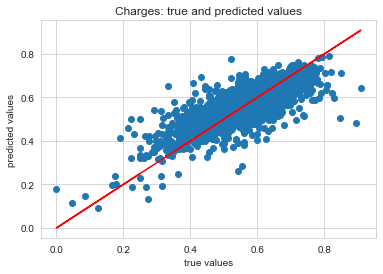

,evaluators,values
0,r^2_train,0.608676
1,r^2_test,0.602853
2,mae,0.054333
3,mse,0.005104
4,rmse,0.071445


breuschpagan: 1.7124673839280504e-66
jarque_bera: (814.8608430114101, 0.0)
normaltest: NormaltestResult(statistic=331.4361097055133, pvalue=1.0704422092975983e-72)


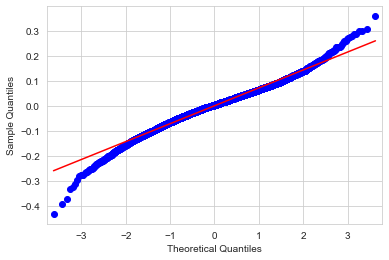

{'lin_reg__normalize': False}


In [135]:
model_metrics(pipeline_cv6)
print(pipeline_cv6.best_params_)

There is a slight improvement in r^2, but the biggest takeaway here is how there is less of a skew in the true vs predicted values.

In [136]:
coef = pipeline_cv6.best_estimator_.named_steps["lin_reg"].coef_
coef_pd = pd.DataFrame({'var':X_train.columns,'coef':coef})
coef_pd =coef_pd.sort_values(axis=0,by='coef',ascending=False)
coef_pd

,var,coef
4,property_type_name_One-to-four family dwelling,0.105718
3,property_type_name_Manufactured housing,0.053665
28,agency_name_Federal Deposit Insurance Corporation,0.022378
20,applicant_sex_name_Unknown,0.022374
14,loan_purpose_name_Home purchase,0.015327
33,loan_amount_log,0.014361
2,tract_to_msamd_income,0.008442
29,agency_name_Federal Reserve System,0.007816
31,number_of_owner_occupied_units_per_cap,0.007756
0,minority_population,0.007191


There is a change in the coefficients.  Within tracts with lower than average median income, minority population has only a -.025 impact as opposed to -.036.  The same variables are prominent.

In [137]:
rich = data_group[data_group['hud_median_family_income']>(data_group['hud_median_family_income'].mean()+data_group['hud_median_family_income'].std())]

In [138]:
# Rich Linear Regression
remove_cols = X_remove_col_master_list+kbest_drop
X= rich.drop(columns=remove_cols)
y= rich['action_taken_binary']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=32)

preprocessing = ColumnTransformer(
    [
        ('scaler', StandardScaler(), X_train.columns)
    ],
    remainder="passthrough",
)

pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ('lin_reg', LinearRegression())
    ], verbose=True
)


grid = {
    'lin_reg__normalize': [True,False]
}

pipeline_cv7 = GridSearchCV(pipeline, grid, verbose=1,cv=5,n_jobs=3)
pipeline_cv7.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s


[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing lin_reg, total=   0.0s


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('scaler',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         Index(['minority_population', 'hud_median_family_income',
       'tract_to_msamd_

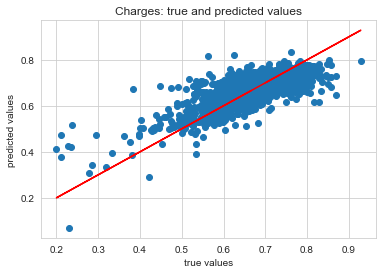

,evaluators,values
0,r^2_train,0.560810
1,r^2_test,0.585217
2,mae,0.041202
3,mse,0.002922
4,rmse,0.054054


breuschpagan: 1.6011331980387638e-110
jarque_bera: (2560.94894815037, 0.0)
normaltest: NormaltestResult(statistic=913.674235988489, pvalue=3.9642453597809154e-199)


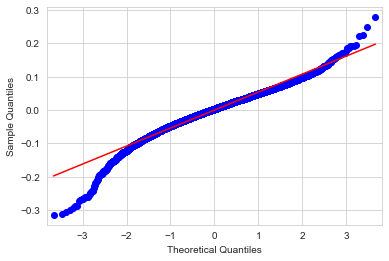

{'lin_reg__normalize': False}


In [139]:
model_metrics(pipeline_cv7)
print(pipeline_cv7.best_params_)

In [140]:
coef = pipeline_cv7.best_estimator_.named_steps["lin_reg"].coef_
coef_pd = pd.DataFrame({'var':X_train.columns,'coef':coef})
coef_pd =coef_pd.sort_values(axis=0,by='coef',ascending=False)
coef_pd

,var,coef
10,owner_occupancy_name_Owner-occupied as a princ...,8.241606e+11
9,owner_occupancy_name_Not owner-occupied as a p...,7.544877e+11
19,applicant_sex_name_Male,2.347876e+11
18,applicant_sex_name_Female,1.873728e+11
8,owner_occupancy_name_Not applicable,1.717499e+11
20,applicant_sex_name_Unknown,1.395402e+11
26,applicant_race_name_1_White,4.191838e-02
22,applicant_race_name_1_Asian,2.603230e-02
33,loan_amount_log,1.628912e-02
4,property_type_name_One-to-four family dwelling,1.273410e-02


For higher income tracts, there isn't much of a difference.  Minority population is only slightly weaker at -.032 than -.036.  Oddly, the positive influencing variables have shifted.  The % of applicants who are Asian became more prominent as opposed to neighboorhood or loan characteristics.

Taken together, this does suggest that there is some sort of interaction variable betwen relative poverty and other features, but the changes are not that different and r^2 does not improve much to justify their addition on top of already fairly multicollinear features.

As practice I ran a gradient booster model.  It suffered from chronic overprediction.

In [141]:
# GradientBooster
remove_cols = X_remove_col_master_list+kbest_drop
X= rich.drop(columns=remove_cols)
y= rich['action_taken_binary']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=32)


preprocessing = ColumnTransformer(
    [
        ('scaler', StandardScaler(), X_train.columns)
    ],
    remainder="passthrough",
)

pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ('grad_boost', GradientBoostingRegressor())
    ], verbose=True
)


grid = {
    'grad_boost__loss': ['ls'],
    'grad_boost__learning_rate' : [.01,.1,1],
    'grad_boost__n_estimators' : [100]
}

pipeline_cv8 = GridSearchCV(pipeline, grid, verbose=1,cv=5,n_jobs=3)
pipeline_cv8.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   24.0s finished


[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing grad_boost, total=   5.9s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('scaler',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         Index(['minority_population', 'hud_median_family_income',
       'tract_to_msamd_

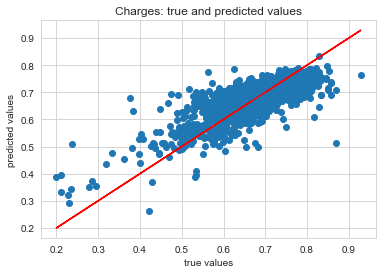

,evaluators,values
0,r^2_train,0.674331
1,r^2_test,0.605506
2,mae,0.039781
3,mse,0.002779
4,rmse,0.052716


breuschpagan: 8.729916728972508e-68
jarque_bera: (573.8104542016192, 0.0)
normaltest: NormaltestResult(statistic=313.0386373561396, pvalue=1.0580923802232729e-68)


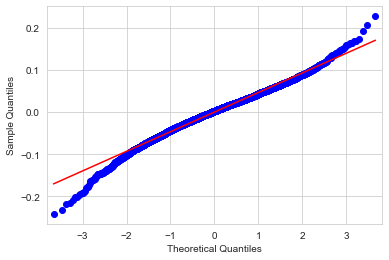

{'grad_boost__learning_rate': 0.1, 'grad_boost__loss': 'ls', 'grad_boost__n_estimators': 100}


In [142]:
model_metrics(pipeline_cv8)
print(pipeline_cv8.best_params_)

As I mentioned before, the model does not perform much better than simpler models.  The chronic overfitting makes this a less desireable model to use.
Feature importance does align with the forest model.

In [143]:

feature_import = pipeline_cv8.best_estimator_.named_steps["grad_boost"].feature_importances_
feature_import_pd = pd.DataFrame({'var':X_train.columns,'importance':feature_import})
feature_import_pd =feature_import_pd.sort_values(axis=0,by='importance',ascending=False)
feature_import_pd

,var,importance
23,applicant_race_name_1_Black or African American,0.224789
0,minority_population,0.141097
24,applicant_race_name_1_Hispanic,0.077378
27,agency_name_Department of Housing and Urban De...,0.071397
33,loan_amount_log,0.067112
1,hud_median_family_income,0.040585
3,property_type_name_Manufactured housing,0.039772
15,loan_purpose_name_Refinancing,0.037493
14,loan_purpose_name_Home purchase,0.030986
20,applicant_sex_name_Unknown,0.028566


In summary, the minority population % does matter, but its exact impact varies by accounting for economic indicators like median income and the nature of the market such as the % of applicants applying for a loan for a 1-4 family dwelling.  The decline in strength of minority population %'s expanatory power for the poor model does justify further exploration into its impact at a more micro level within more affluent communities to better address the mechanics behind the differences the models here suggest.